In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from educational_ai_analytics.config import W_WINDOWS

BASE_PROCESSED = Path("/workspace/TFM_education_ai_analytics/data/2_processed/training")
BASE_TARGET = Path("/workspace/TFM_education_ai_analytics/data/3_features/training/target.csv")

# Carga
interactions_df = pd.read_csv(
    BASE_PROCESSED / "interactions.csv",
    index_col=None
    )

# Evitar alumnos que ya han abandonado antes de la semana objeto de predicción
students_df = pd.read_csv(BASE_PROCESSED / "students.csv", index_col=None, usecols=["code_module", "code_presentation", "id_student", "date_unregistration"])

students_df["unique_id"] = (
    students_df["id_student"].astype(str)
    .str.cat(students_df["code_module"].astype(str), sep="_")
    .str.cat(students_df["code_presentation"].astype(str), sep="_")
)

students_df["week_unregistration"] = (
    pd.to_numeric(students_df["date_unregistration"], errors="coerce").fillna(9999) // 7
).astype(int)

target_full = pd.read_csv(BASE_TARGET, index_col=0).sort_index()

# Robustez columna clicks
click_col = "sum_click" if "sum_click" in interactions_df.columns else "clicks"
if click_col not in interactions_df.columns:
    raise ValueError("No se encontró ni 'sum_click' ni 'clicks' en interactions.csv")

# Limpieza y unique_id
interactions_df["activity_type"] = interactions_df["activity_type"].astype(str).str.strip().str.lower()
interactions_df["unique_id"] = (
    interactions_df["id_student"].astype(str)
    .str.cat(interactions_df["code_module"].astype(str), sep="_")
    .str.cat(interactions_df["code_presentation"].astype(str), sep="_")
)

# Semana 0-based
interactions_df["week"] = (
    pd.to_numeric(interactions_df["date"], errors="coerce").fillna(-9999) // 7
).astype(int)

# Base temporal válida
interactions_base = interactions_df[interactions_df["week"] >= 0].copy()

# Actividades globales (mismo F para todas las ventanas)
activities_global = sorted(interactions_base["activity_type"].unique().tolist())

sequences = {f"upto_{w}": None for w in sorted(W_WINDOWS)}
masks = {f"upto_{w}": None for w in sorted(W_WINDOWS)}
labels = {f"upto_{w}": None for w in sorted(W_WINDOWS)}
ids = {f"upto_{w}": None for w in sorted(W_WINDOWS)}

for upto_week in sorted(W_WINDOWS):
    inter_uptoW = interactions_base[interactions_base["week"] < upto_week].copy()
    active_students = students_df[students_df["week_unregistration"] >=upto_week]
    valid_ids = active_students["unique_id"].unique()
    total_students = inter_uptoW["unique_id"].nunique()
    print(f"Se van a eliminar {total_students - len(valid_ids) } estudiantes por abandonar antes de la semana {upto_week}")
    inter_uptoW = inter_uptoW[inter_uptoW["unique_id"].isin(valid_ids)]

    g = (
        inter_uptoW.groupby(["unique_id", "week", "activity_type"], as_index=False)[click_col]
        .sum()
        .rename(columns={click_col: "sum_click"})
    )

    weeks = list(range(upto_week))
    full_cols = pd.MultiIndex.from_product(
        [weeks, activities_global], names=["week", "activity_type"]
    )

    wide = (
        g.pivot_table(
            index="unique_id",
            columns=["week", "activity_type"],
            values="sum_click",
            aggfunc="sum",
            fill_value=0,
        )
        .reindex(columns=full_cols, fill_value=0)
        .sort_index()
    )

    # Orden estable basado en target (mejor para trazabilidad y evaluación)
    common_ids = target_full.index.intersection(wide.index)
    wide_w = wide.loc[common_ids]
    target_w = target_full.loc[common_ids]



    X_seq = wide_w.values.reshape(len(wide_w), upto_week, len(activities_global)).astype(np.float32)
    mask = (X_seq.sum(axis=2) > 0).astype(np.int32)
    y = target_w["final_result"].astype(np.int64).values

    key = f"upto_{upto_week}"
    sequences[key] = X_seq
    masks[key] = mask
    labels[key] = y
    ids[key] = common_ids

    print(f"======== WEEK {upto_week} ========")
    print("X_seq:", X_seq.shape)
    print("mask :", mask.shape)
    print("y    :", y.shape)
    print("n_activities:", len(activities_global))
    print("classes:", np.unique(y, return_counts=True))
    print("================================")

# Ejemplo de consumo consistente:
W_KEY = f"upto_{sorted(W_WINDOWS)[0]}"
X = sequences[W_KEY]
M = masks[W_KEY]
y = labels[W_KEY]
uid = ids[W_KEY]

print("\nW_KEY:", W_KEY, "| X:", X.shape, "| M:", M.shape, "| y:", y.shape, "| ids:", len(uid))

KeyboardInterrupt: 

## Features derivadas del clustering

In [ ]:
from pathlib import Path
from educational_ai_analytics.config import W_WINDOWS
import pandas as pd 
import numpy as np

BASE_SEGMENTED = Path("/workspace/TFM_education_ai_analytics/data/5_students_segmented")

features_cluster = [
    'p_cluster_0', 'p_cluster_1', 'p_cluster_2', 
    'p_cluster_3', 'p_cluster_4', 'entropy_norm'
]

static_data = {f"upto_{w}": None for w in sorted(W_WINDOWS)}

for upto_week in sorted(W_WINDOWS):
    W_KEY = f"upto_{upto_week}"
    file_path = BASE_SEGMENTED / 'training' / f"students_segmented_uptoW{upto_week}.csv"
    
    cols_to_load = ["unique_id"] + features_cluster
    segmented_df = pd.read_csv(file_path, usecols=cols_to_load)
    segmented_df.set_index("unique_id", inplace=True)

    uid_w = ids[W_KEY]

    X_static_df = segmented_df.reindex(uid_w).fillna(0)
    
    static_data[W_KEY] = X_static_df.values.astype(np.float32)
    
    print(f"Procesada ventana {W_KEY}: {static_data[W_KEY].shape}")
    del segmented_df

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/TFM_education_ai_analytics/data/5_students_segmented/training/students_segmented_uptoW5.csv'

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class PositionalEncoding(layers.Layer):
    def __init__(self, d_model: int, max_len: int = 512):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len

        pos = tf.range(max_len, dtype=tf.float32)[:, tf.newaxis]   # (L, 1)
        i = tf.range(self.d_model, dtype=tf.float32)[tf.newaxis, :]     # (1, D)

        angle_rates = 1.0 / tf.pow(10000.0, (2.0 * tf.floor(i / 2.0)) / tf.cast(self.d_model, tf.float32))
        angle_rads = pos * angle_rates

        sin_part = tf.sin(angle_rads[:, 0::2])
        cos_part = tf.cos(angle_rads[:, 1::2])

        pe = tf.concat([sin_part, cos_part], axis=-1)              # (L, D)
        self.pe = pe[tf.newaxis, ...]                              # (1, L, D)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pe[:, :seq_len, :]


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, d_model: int, num_heads: int, ff_dim: int, dropout: float):
        super().__init__()
        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
            dropout=dropout,
        )
        self.dropout1 = layers.Dropout(dropout)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.add1 = layers.Add()

        self.ffn = tf.keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dropout(dropout),
                layers.Dense(d_model),
            ]
        )
        self.dropout2 = layers.Dropout(dropout)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.add2 = layers.Add()

    def call(self, x, training=False, attention_mask=None):
        attn_out = self.mha(
            query=x,
            key=x,
            value=x,
            attention_mask=attention_mask,
            training=training,
        )
        attn_out = self.dropout1(attn_out, training=training)
        x = self.add1([x, attn_out])
        x = self.norm1(x)

        ffn_out = self.ffn(x, training=training)
        ffn_out = self.dropout2(ffn_out, training=training)
        x = self.add2([x, ffn_out])
        x = self.norm2(x)
        return x


class GLULayer(layers.Layer):
    def __init__(self, d_model: int):
        super().__init__()
        self.proj = layers.Dense(2 * d_model)

    def call(self, x):
        z = self.proj(x)
        a, b = tf.split(z, num_or_size_splits=2, axis=-1)
        return a * tf.sigmoid(b)


class GLUTransformerClassifier(tf.keras.Model):
    def __init__(
        self,
        latent_d: int,
        num_heads: int,
        ff_dim: int,
        dropout: float,
        num_classes: int,
        num_layers: int = 2,
        max_len: int = 512,
        static_dim: int = 128,
        static_hidden: list[int] = [32,64],
        with_static_features: bool = True
    ):
        super().__init__()
        self.with_static_features = with_static_features

        "================ FEATURES ESTATICAS ================"

        if self.with_static_features:
            self.static_block = tf.keras.Sequential([
                layers.Dense(n_neurons, activation='relu')
                for n_neurons in static_hidden  
            ])

        if latent_d % num_heads != 0:
            raise ValueError("latent_d debe ser divisible por num_heads")

        "================ FEATURES TEMPORALES ================"
        self.input_proj = layers.Dense(latent_d)
        self.pos_encoding = PositionalEncoding(d_model=latent_d, max_len=max_len)
        self.input_dropout = layers.Dropout(dropout)

        self.encoders = [
            TransformerEncoderBlock(
                d_model=latent_d,
                num_heads=num_heads,
                ff_dim=ff_dim,
                dropout=dropout,
            )
            for _ in range(num_layers)
        ]


        self.glu = GLULayer(d_model=latent_d)
        self.norm_out = layers.LayerNormalization(epsilon=1e-6)


        " =============== ESTATICAS + DINAMICAS ======== "
        if self.with_static_features:
            self.fusion = layers.Concatenate(axis=-1)

        " =============== CABEZA FINAL ======== "
        self.head_dropout = layers.Dropout(dropout)
        self.head_dense = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs, training=False, mask=None):
        if isinstance(inputs, (tuple, list)):
            if(self.with_static_features and len(inputs) == 3):
                x_seq, seq_mask, x_static = inputs
            elif(not self.with_static_features and len(inputs) == 2):
                x_seq, seq_mask = inputs
                x_static = None
            else:
                raise ValueError("Algo va mal con el batch de entrada")
        else:
            raise ValueError("Algo va mal con el batch de entrada")

        #============= FEATURES STATICAS ====================#
        if self.with_static_features:
            x_static = self.static_block(x_static)

        #============= FEATURES TEMPORALES ===================#
        x_seq = self.input_proj(x_seq)                  # (B, W, D)
        x_seq = self.pos_encoding(x_seq)                # (B, W, D)
        x_seq = self.input_dropout(x_seq, training=training)

        # Mask para atención: (B, 1, W) -> broadcast interno a (B, W, W)
        attn_mask = None
        if seq_mask is not None:
            attn_mask = tf.cast(seq_mask[:, tf.newaxis, :], tf.bool)

        for encoder in self.encoders:
            x_seq = encoder(x_seq, training=training, attention_mask=attn_mask)

        x_seq = self.glu(x_seq)
        x_seq = self.norm_out(x_seq)

        # Masked pooling temporal
        m = tf.cast(seq_mask, x_seq.dtype)[:, :, tf.newaxis]  # (B, W, 1)
        pooled = tf.reduce_sum(x_seq * m, axis=1) / (tf.reduce_sum(m, axis=1) + 1e-8)
        
        if self.with_static_features:
            fusion = self.fusion([x_static ,pooled])
        else:
            fusion = pooled
        
        fusion = self.head_dropout(fusion, training=training)
        return self.head_dense(fusion)

## Binzarizar, Trinarizar o Cuaternizar el problema

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

def get_stratified_splits(sequences, masks, static_features, labels, num_classes=2, paper_baseline=True, test_size=0.2, random_state=42):
    """
    Divide los datos en entrenamiento y validación manteniendo la proporción de clases.
    Etiquetas originales: 0=Fail, 1=Withdrawn, 2=Pass, 3=Distinction
    """
    X_seq, X_mask, X_static, y = sequences.copy(), masks.copy(), static_features.copy(), labels.copy()

    if num_classes == 2:
        if paper_baseline:
            # Configuración del Paper: Abandono (1) vs Éxito (2,3). Excluye Fail (0).
            valid_mask = (y != 0)
            X_seq, X_mask, X_static, y = X_seq[valid_mask], X_mask[valid_mask], X_static[valid_mask], y[valid_mask]
            
            # Mapeo: Withdrawn (1) -> 1 (Positivo), Pass/Dist (2,3) -> 0 (Negativo)
            y_formatted = np.where(y == 1, 1, 0)
            print("Configuración 2 clases (Baseline Paper): [0: Pass/Dist] vs [1: Withdrawn]. (Fail eliminados)")
        else:
            # Tu configuración original: Fail (0) vs Éxito (2,3). Excluye Withdrawn (1).
            valid_mask = (y != 1)
            X_seq, X_mask, X_static, y = X_seq[valid_mask], X_mask[valid_mask], X_static[valid_mask], y[valid_mask]
            
            # Mapeo: Fail (0) -> 0 (Negativo), Pass/Dist (2,3) -> 1 (Positivo)
            y_formatted = np.where(y == 0, 0, 1)
            print("Configuración 2 clases (Tu Original): [0: Fail] vs [1: Pass/Dist]. (Withdrawn eliminados)")

    elif num_classes == 3:
        # Modo Trinario: Fail (0) vs Withdrawn (1) vs Éxito (2)
        y_formatted = np.where(y >= 2, 2, y)
        print("Configuración 3 clases: [0: Fail], [1: Withdrawn], [2: Pass/Dist]")

    elif num_classes == 4:
        # Modo Cuaternario: Todas las originales
        y_formatted = y
        print("Configuración 4 clases: [0: Fail], [1: Withdrawn], [2: Pass], [3: Distinction]")
    
    else:
        raise ValueError("num_classes debe ser 2, 3 o 4.")

    # Split
    (train_seq, val_seq, 
     train_mask, val_mask, 
     train_static, val_static, 
     train_labels, val_labels) = train_test_split(
        X_seq, X_mask, X_static, y_formatted,
        test_size=test_size,
        random_state=random_state,
        stratify=y_formatted
    )

    # Class weights
    unique_classes = np.unique(train_labels)
    weights_values = compute_class_weight('balanced', classes=unique_classes, y=train_labels)
    cw = dict(zip(unique_classes, weights_values))

    return (train_seq, val_seq, train_mask, val_mask, train_static, val_static, train_labels, val_labels, cw)

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# ---------- 1. Configuración y Carga de Datos Estáticos ----------
NUM_CLASSES = 2
W_KEY = "upto_10" 
WITH_STATIC_FEATURES = True
print(f"NUM_CLASSES: {NUM_CLASSES}")
print(f"W_KEY: {W_KEY}")
print(f"WITH_STATIC_FEATURES: {WITH_STATIC_FEATURES}")

# ---------- 2. Split Estratificado (Human-Friendly) ----------
(train_seq, val_seq, 
 train_mask, val_mask, 
 train_static, val_static, 
 train_y, val_y, 
 cw) = get_stratified_splits(
    sequences=sequences[W_KEY].astype(np.float32),
    masks=masks[W_KEY].astype(np.int32),
    static_features=static_data[W_KEY],
    labels=labels[W_KEY].astype(np.int64),
    num_classes=NUM_CLASSES
)

# === NUEVO: Imprimir el balanceo de clases ===
train_classes, train_counts = np.unique(train_y, return_counts=True)
val_classes, val_counts = np.unique(val_y, return_counts=True)

print("\n" + "="*40)
print("📊 BALANCEO DE CLASES")
print("="*40)
print("Conjunto de Entrenamiento:")
for cls, count in zip(train_classes, train_counts):
    porcentaje = (count / len(train_y)) * 100
    print(f"  ➤ Clase {cls}: {count} estudiantes ({porcentaje:.2f}%)")

print("\nConjunto de Validación:")
for cls, count in zip(val_classes, val_counts):
    porcentaje = (count / len(val_y)) * 100
    print(f"  ➤ Clase {cls}: {count} estudiantes ({porcentaje:.2f}%)")
print("="*40 + "\n")

final_training_set = [train_seq, train_mask]
final_validation_set = [val_seq, val_mask]

if (WITH_STATIC_FEATURES):
    final_training_set.append(train_static)
    final_validation_set.append(val_static)

# ---------- 3. Definición del Modelo ----------
model = GLUTransformerClassifier(
    latent_d=512,
    num_heads=8,
    ff_dim=2048,
    dropout=0.1,
    num_classes=NUM_CLASSES, 
    num_layers=2,
    max_len=train_seq.shape[1], # Adaptado al tamaño real de la ventana
    with_static_features=WITH_STATIC_FEATURES
)

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=1e-4,
    weight_decay=1e-4
)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=[
        "accuracy", 
    ]
)

# ---------- 4. Callbacks ----------
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# ---------- 5. Entrenamiento ----------
# Pasamos la tupla con (Secuencias, Máscaras, Estáticas)
history = model.fit(
    x=final_training_set,
    y=train_y,
    validation_data=(final_validation_set, val_y),
    epochs=80,
    batch_size=256,
    class_weight=cw, # Usando el diccionario de pesos calculado
    callbacks=callbacks,
    verbose=1
)

# ---------- 6. Evaluación ----------
results = model.evaluate(final_validation_set, val_y, verbose=0)

# CORRECCIÓN: 'results' ahora solo tiene 2 elementos: [0] es Loss, [1] es Accuracy
print(f"\nLoss: {results[0]:.4f} | Accuracy: {results[1]:.4f}")

# Si quieres ver el AUC sin que rompa el entrenamiento, calcúlalo aquí con sklearn:
from sklearn.metrics import roc_auc_score
y_probs = model.predict(final_validation_set, verbose=0)

if NUM_CLASSES == 2:
    auc_val = roc_auc_score(val_y, y_probs[:, 1]) # Probabilidad de la clase positiva
else:
    auc_val = roc_auc_score(val_y, y_probs, multi_class='ovr')

print(f"AUC (calculado externamente): {auc_val:.4f}")
print("Mejor Accuracy en Val:", max(history.history["val_accuracy"]))

NUM_CLASSES: 2
W_KEY: upto_12
WITH_STATIC_FEATURES: True
Configuración 2 clases (Baseline Paper): [0: Pass/Dist] vs [1: Withdrawn]. (Fail eliminados)

📊 BALANCEO DE CLASES
Conjunto de Entrenamiento:
  ➤ Clase 0: 8566 estudiantes (70.07%)
  ➤ Clase 1: 3659 estudiantes (29.93%)

Conjunto de Validación:
  ➤ Clase 0: 2142 estudiantes (70.07%)
  ➤ Clase 1: 915 estudiantes (29.93%)

Epoch 1/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 68s 784ms/step - accuracy: 0.6052 - loss: 0.7985 - val_accuracy: 0.5849 - val_loss: 0.6747 - learning_rate: 1.0000e-04
Epoch 2/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.6527 - loss: 0.6203 - val_accuracy: 0.7491 - val_loss: 0.5250 - learning_rate: 1.0000e-04
Epoch 3/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.6578 - loss: 0.6201 - val_accuracy: 0.7455 - val_loss: 0.5245 - learning_rate: 1.0000e-04
Epoch 4/80
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.6780 - loss: 0.5955 - val_accuracy: 0.6591 - val_loss: 0.6039 - learning_rate: 1.0000e-0

macro_f1     : 0.7646
weighted_f1  : 0.8113
balanced_acc : 0.7452

Classification report:
              precision    recall  f1-score   support

           0     0.7761    0.5585    0.6496       906
           1     0.8331    0.9318    0.8797      2142

    accuracy                         0.8209      3048
   macro avg     0.8046    0.7452    0.7646      3048
weighted avg     0.8161    0.8209    0.8113      3048



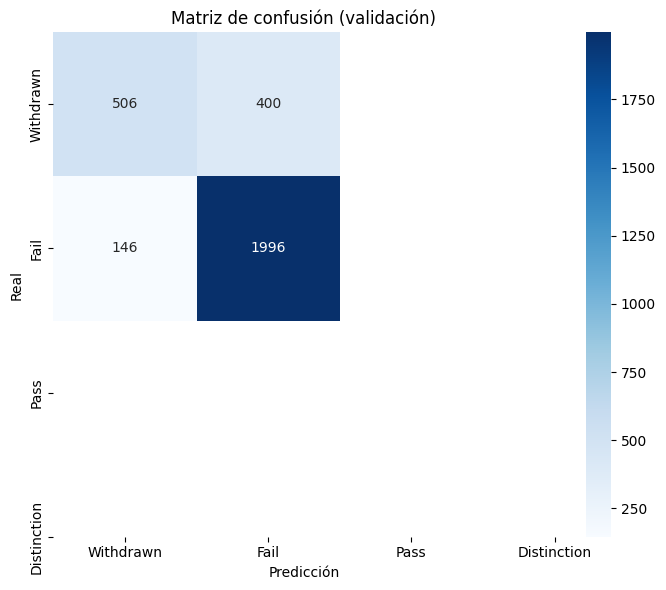

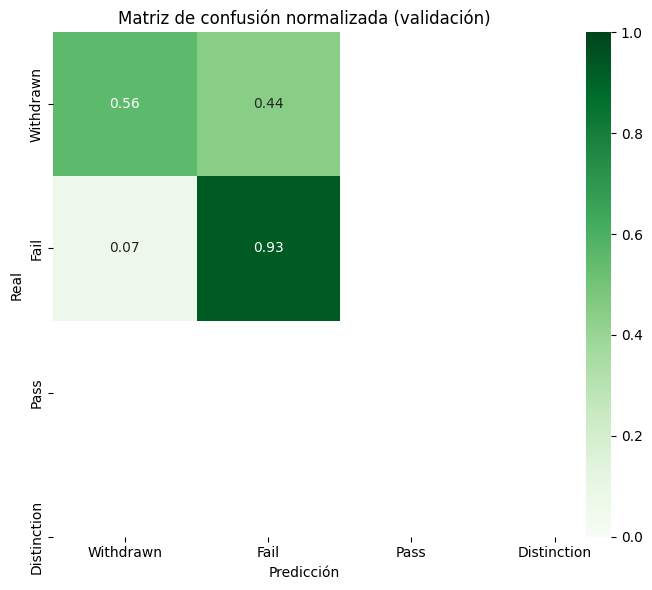

In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    balanced_accuracy_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predicción en validación
y_proba = model.predict((X_va, M_va), verbose=0)
y_pred = np.argmax(y_proba, axis=1)

# Métricas clave multiclase
macro_f1 = f1_score(y_va, y_pred, average="macro")
weighted_f1 = f1_score(y_va, y_pred, average="weighted")
bal_acc = balanced_accuracy_score(y_va, y_pred)

print(f"macro_f1     : {macro_f1:.4f}")
print(f"weighted_f1  : {weighted_f1:.4f}")
print(f"balanced_acc : {bal_acc:.4f}")
print("\nClassification report:")
print(classification_report(y_va, y_pred, digits=4))

# Matriz de confusión (absoluta)
cm = confusion_matrix(y_va, y_pred)
labels_txt = ["Withdrawn", "Fail", "Pass", "Distinction"]  # 0,1,2,3

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=labels_txt, yticklabels=labels_txt
)
plt.title("Matriz de confusión (validación)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# Matriz de confusión normalizada por clase real
cm_norm = cm / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_norm, annot=True, fmt=".2f", cmap="Greens", vmin=0, vmax=1,
    xticklabels=labels_txt, yticklabels=labels_txt
)
plt.title("Matriz de confusión normalizada (validación)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()